In [1]:
import os
import io
import sys
import shutil
import zipfile
import hashlib
import contextlib

if sys.version_info < (3,):
    from urllib2 import urlopen
else:
    from urllib.request import urlopen

URL = 'https://zenodo.org/record/841982/files/xflr6/portmanteaus-v1.0.zip'
CSV = 'esm3-analyses.csv'

def sha256sum(filename, bufsize=32768):
    s = hashlib.sha256()
    with io.open(filename, 'rb') as fd:
        while True:
            data = fd.read(bufsize)
            if not data:
                break
            s.update(data)
    return s.hexdigest()

if not os.path.exists(CSV):
    with io.BytesIO() as b:
        with contextlib.closing(urlopen(URL)) as u:
            shutil.copyfileobj(u, b)
        with zipfile.ZipFile(b) as z:
            i, = (i for i in z.infolist() if i.filename.endswith(CSV))
            i.filename = CSV
            z.extract(i)

sha256sum(CSV)

'6e6389a913cc01020d03ac16217bc1c63c9d0e16b78179b4c931741c0d5a69cf'

In [2]:
%matplotlib inline

import re

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

plt.style.use('classic')
plt.rcParams.update({
    'figure.figsize': (6, 4), 'figure.facecolor': 'w',
    'figure.subplot.bottom': .125, 'font.size': 10, 'savefig.dpi': 72,
})

def pearsonr(df, left, right, func=scipy.stats.pearsonr):
    df = df[[left, right]].dropna()
    name = '%s & %s' % (left, right)
    with np.errstate(invalid='ignore'):
        result = func(df[left], df[right])
    return pd.Series(result, index=('r', 'p'), name=name)

RENAME = {'Quechua (Ayacucho)': 'Ayacucho', 'Tlachichilco Tepehuan': 'Tepehua', 'Lakhota': 'Lakota'}

cf = pd.read_csv(CSV, encoding='utf-8')

cf['Language'] = cf['Language'].replace(RENAME)

cf.info()
cf.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2818 entries, 0 to 2817
Data columns (total 5 columns):
Language    2818 non-null object
Cell        2818 non-null object
Position    2818 non-null int64
Form        2818 non-null object
Meaning     2818 non-null object
dtypes: int64(1), object(4)
memory usage: 110.2+ KB


,Language,Cell,Position,Form,Meaning
0,Ainu,1s,-1,ku,SA[+1 +sg]
1,Ainu,1p,1,as,S[+1 +pl]
2,Ainu,2s,-1,e,SAP[-3 +sg]
3,Ainu,2p,-1,eci,SAP[+2]
4,Ainu,x,1,an,S[-1 -2 -3]
5,Ainu,1s->2s,-1,eci,SAP[+2]
6,Ainu,1s->2p,-1,eci,SAP[+2]
7,Ainu,1s->3s,-1,ku,SA[+1 +sg]
8,Ainu,1s->3p,-1,ku,SA[+1 +sg]
9,Ainu,1s->x,-2,ku,SA[+1 +sg]


In [3]:
STEM = 'Σ'

assert not cf['Form'].str.contains(STEM).any()

_cf = cf.drop('Meaning', axis=1)\
    .assign(cell_index=lambda x: x.groupby(['Language', 'Cell'], sort=False).ngroup())

_sf = _cf.drop_duplicates('cell_index').assign(Position=0, Form=STEM)

df = pd.concat([_cf, _sf]).sort_values(by=['cell_index', 'Position']).groupby('cell_index')\
    .agg({'Language': 'first', 'Cell': 'first', 'Form': 'sum'}).reset_index(drop=True)

df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1317 entries, 0 to 1316
Data columns (total 3 columns):
Language    1317 non-null object
Cell        1317 non-null object
Form        1317 non-null object
dtypes: object(3)
memory usage: 30.9+ KB


,Language,Cell,Form
0,Ainu,1s,kuΣ
1,Ainu,1p,Σas
2,Ainu,2s,eΣ
3,Ainu,2p,eciΣ
4,Ainu,x,Σan
5,Ainu,1s->2s,eciΣ
6,Ainu,1s->2p,eciΣ
7,Ainu,1s->3s,kuΣ
8,Ainu,1s->3p,kuΣ
9,Ainu,1s->x,kuiΣ


In [4]:
SEP = '->'

def is_distinct_local(cellkey, sep=SEP, persons=('1', '2')):
    subj, trans, obj = cellkey.partition(sep)
    local_subj, local_obj = (any(p in arg for p in persons) for arg in (subj, obj))
    if local_subj and local_obj:
        return True
    elif trans and (local_subj or local_obj):
        return False
    else:
        return None

df.insert(2, 'DisLocal', df['Cell'].map(is_distinct_local))

df.head(30)

,Language,Cell,DisLocal,Form
0,Ainu,1s,None,kuΣ
1,Ainu,1p,None,Σas
2,Ainu,2s,None,eΣ
3,Ainu,2p,None,eciΣ
4,Ainu,x,None,Σan
5,Ainu,1s->2s,True,eciΣ
6,Ainu,1s->2p,True,eciΣ
7,Ainu,1s->3s,False,kuΣ
8,Ainu,1s->3p,False,kuΣ
9,Ainu,1s->x,False,kuiΣ


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1317 entries, 0 to 1316
Data columns (total 4 columns):
Language    1317 non-null object
Cell        1317 non-null object
DisLocal    912 non-null object
Form        1317 non-null object
dtypes: object(4)
memory usage: 41.2+ KB


In [6]:
xf = df[df['DisLocal'].notnull()].groupby(['Language', 'DisLocal'])['Form'].agg(['size', 'nunique'])

xf['neut'] = xf['size'] - xf['nunique']
xf['ratio'] = 100 * xf['neut'] / (xf['size'] - 1)
xf['ratio (norm)'] = xf['ratio'] / xf['ratio'].sum(level='Language')
xf.loc[xf['ratio (norm)'].isnull(), 'ratio'] = None

xfp = xf.reset_index('DisLocal')
xf = xf.unstack()

xf

size       nunique        neut            ratio             \
DisLocal    False True    False True  False True       False      True    
Language                                                                  
Ainu           24     8      14     5    10     3  43.478261  42.857143   
Aleut          36    18      13     5    23    13  65.714286  76.470588   
Ayacucho       20     8      11     6     9     2  47.368421  28.571429   
Bella Coola    16     8      13     6     3     2  20.000000  28.571429   
Chuckchi       15     8       7     6     8     2  57.142857  28.571429   
Darai          16     8      11     5     5     3  33.333333  42.857143   
Fox            20     8      16     6     4     2  21.052632  28.571429   
Hixkaryana     18     6       7     3    11     3  64.705882  60.000000   
Jaqaru          6     3       5     3     1     0  20.000000   0.000000   
Jumjum         24     8      17     8     7     0  30.434783   0.000000   
Karuk          16     8       9     5     7     3  46.666667  42.857143   
Ket            48     8      22     8    26     0  55.319149   0.000000   
Kunama         48    18      22     7    26    11  55.319149  64.705882   
Lakota         20     8      13     6     7     2  36.842105  28.571429   
Maricopa       16     8       3     2    13     6  86.666667  85.714286   
Maung          60     8      45     4    15     4  25.423729  57.142857   
Mordvin        16     8      10     4     6     4  40.000000  57.142857   
Nocte          16     8       6     3    10     5  66.666667  71.428571   
Reyesano       16     8       8     2     8     6  53.333333  85.714286   
Sahu           60     8      30     8    30     0  50.847458   0.000000   
Siuslawan      48    18      48    17     0     1   0.000000   5.882353   
Tepehua        20     8      15     4     5     4  26.315789  57.142857   
Thangmi        16     8      10     6     6     2  40.000000  28.571429   
Turkana        16     8       7     3     9     5  60.000000  71.428571   
Wardaman       24     8      23     7     1     1   4.347826  14.285714   
Yimas          36    18      30    17     6     1  17.142857   5.882353   

            ratio (norm)            
DisLocal           False     True   
Language                            
Ainu            0.503597  0.496403  
Aleut           0.462175  0.537825  
Ayacucho        0.623762  0.376238  
Bella Coola     0.411765  0.588235  
Chuckchi        0.666667  0.333333  
Darai           0.437500  0.562500  
Fox             0.424242  0.575758  
Hixkaryana      0.518868  0.481132  
Jaqaru          1.000000  0.000000  
Jumjum          1.000000  0.000000  
Karuk           0.521277  0.478723  
Ket             1.000000  0.000000  
Kunama          0.460897  0.539103  
Lakota          0.563218  0.436782  
Maricopa        0.502762  0.497238  
Maung           0.307918  0.692082  
Mordvin         0.411765  0.588235  
Nocte           0.482759  0.517241  
Reyesano        0.383562  0.616438  
Sahu            1.000000  0.000000  
Siuslawan       0.000000  1.000000  
Tepehua         0.315315  0.684685  
Thangmi         0.583333  0.416667  
Turkana         0.456522  0.543478  
Wardaman        0.233333  0.766667  
Yimas           0.744526  0.255474

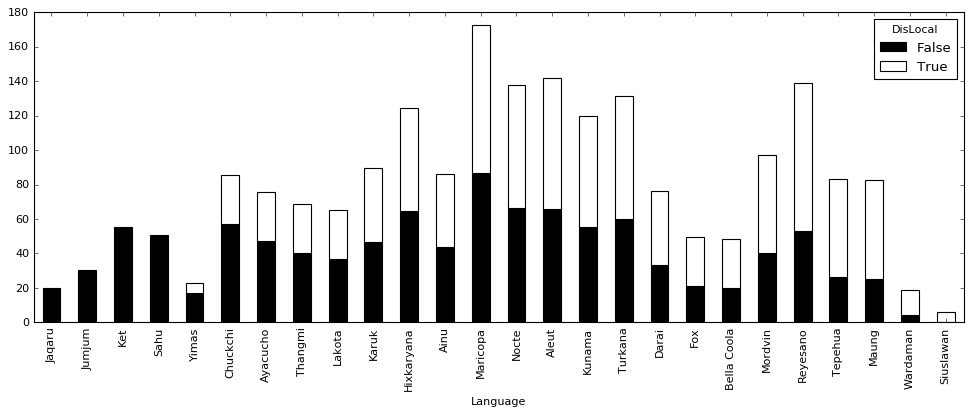

In [7]:
xf.sort_values(by=('ratio (norm)', True), kind='mergesort')['ratio']\
    .plot.bar(stacked=True, figsize=(15, 5), cmap=plt.cm.gray);

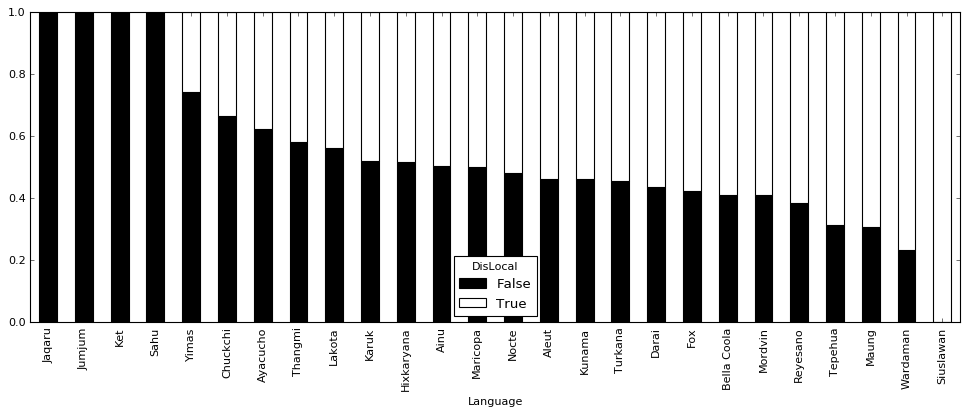

In [8]:
xf['ratio (norm)'].sort_values(by=True, kind='mergesort')\
    .plot.bar(stacked=True, figsize=(15, 5), cmap=plt.cm.gray);

In [9]:
pd.DataFrame([pearsonr(xfp, 'DisLocal', c) for c in ['ratio', 'ratio (norm)']])

,r,p
DisLocal & ratio,-0.043886,0.757379
DisLocal & ratio (norm),-0.159971,0.257281


In [10]:
FIRST, SECOND, SAP = (re.compile(s) for s in (r'1', '2|[dp]i', r'[12]'))

ff = df[df['DisLocal'].notnull()].copy()
ff[['A', 'P']] = ff['Cell'].str.partition(SEP)[[0, 2]]
print(ff['A'].append(ff['P']).unique())

groups = {
    '1->X:P': lambda x: x['A'].str.contains(FIRST) & ~x['P'].str.contains(SAP),
    '2->X:P': lambda x: x['A'].str.contains(SECOND) & ~x['P'].str.contains(SAP),
    'X->1:A': lambda x: ~x['A'].str.contains(SAP) & x['P'].str.contains(FIRST),
    'X->2:A': lambda x: ~x['A'].str.contains(SAP) & x['P'].str.contains(SECOND),
#
    '1->2:A': lambda x: x['A'].str.contains(FIRST) & x['P'].str.contains(SECOND),
    '2->1:A': lambda x: x['A'].str.contains(SECOND) & x['P'].str.contains(FIRST),
    '1->2:P': lambda x: x['A'].str.contains(FIRST) & x['P'].str.contains(SECOND),
    '2->1:P': lambda x: x['A'].str.contains(SECOND) & x['P'].str.contains(FIRST),
}

lf = pd.concat([
    ff[f].groupby(['Language', g.rpartition(':')[-1]])['Form'].agg(['size', 'nunique'])\
    .assign(group=g).set_index('group', append=True).swaplevel(-1, -2)
    for g, f in groups.items()]).sort_index()
lf.index.rename('X', level=2, inplace=True)

lf['neut'] = lf['size'] - lf['nunique']
lf['ratio'] = 100 * lf['neut'] / (lf['size'] - 1)

lf.head(14)

['1s' '1p' '2s' '2p' '3s' '3p' 'x' '1d' '2d' '3d' '1pe' '1pi' '1' '12' '2'
 '3' '1di' '3s.m' '3s.f' '3s.n' '3p.m' '3p.f' '3p.n' '1de' '3.I' '3.III'
 '3.II' '3.IV' '3.V' '3.VI']


size  nunique  neut  ratio
Language group  X                             
Ainu     1->2:A 1p     2        1     1  100.0
                1s     2        1     1  100.0
         1->2:P 2p     2        1     1  100.0
                2s     2        1     1  100.0
         1->X:P 3p     2        2     0    0.0
                3s     2        2     0    0.0
                x      2        2     0    0.0
         2->1:A 2p     2        2     0    0.0
                2s     2        2     0    0.0
         2->1:P 1p     2        2     0    0.0
                1s     2        2     0    0.0
         2->X:P 3p     2        2     0    0.0
                3s     2        2     0    0.0
                x      2        2     0    0.0

In [11]:
def is_local(groupkey, sep=SEP, persons=('1', '2')):
    subj, _, obj = groupkey.rpartition(':')[0].partition(sep)
    return any(p in subj for p in persons) and any(p in obj for p in persons)

llf = lf.reset_index().groupby(['Language', 'group'], as_index=False)[['ratio']].mean()
llf.insert(1, 'local', llf['group'].map(is_local))

llf.head(6)

,Language,local,group,ratio
0,Ainu,True,1->2:A,100.0
1,Ainu,True,1->2:P,100.0
2,Ainu,False,1->X:P,0.0
3,Ainu,True,2->1:A,0.0
4,Ainu,True,2->1:P,0.0
5,Ainu,False,2->X:P,0.0


In [12]:
rf = llf.groupby(['Language', 'local'])[['ratio']].mean()
rf['ratio (norm)'] = rf['ratio'] /  rf['ratio'].sum(level='Language')
rf.loc[rf['ratio (norm)'].isnull(), 'ratio'] = None

rfp = rf.reset_index('local')
rf = rf.unstack()

rf

ratio             ratio (norm)          
local         False       True         False     True 
Language                                              
Ainu           0.00   50.000000     0.000000  1.000000
Aleut         62.50   62.500000     0.500000  0.500000
Ayacucho       6.25   25.000000     0.200000  0.800000
Bella Coola    0.00   12.500000     0.000000  1.000000
Chuckchi      25.00   25.000000     0.500000  0.500000
Darai         25.00   37.500000     0.400000  0.600000
Fox           12.50   25.000000     0.333333  0.666667
Hixkaryana    25.00   66.666667     0.272727  0.727273
Jaqaru          NaN         NaN          NaN       NaN
Jumjum          NaN         NaN          NaN       NaN
Karuk          0.00   37.500000     0.000000  1.000000
Ket             NaN         NaN          NaN       NaN
Kunama        31.25   54.166667     0.365854  0.634146
Lakota        25.00   25.000000     0.500000  0.500000
Maricopa     100.00  100.000000     0.500000  0.500000
Maung          0.00   50.000000     0.000000  1.000000
Mordvin       25.00   50.000000     0.333333  0.666667
Nocte         50.00   75.000000     0.400000  0.600000
Reyesano       0.00   50.000000     0.000000  1.000000
Sahu            NaN         NaN          NaN       NaN
Siuslawan       NaN         NaN          NaN       NaN
Tepehua       18.75   50.000000     0.272727  0.727273
Thangmi        0.00   25.000000     0.000000  1.000000
Turkana       25.00   50.000000     0.333333  0.666667
Wardaman       0.00   12.500000     0.000000  1.000000
Yimas          0.00    4.166667     0.000000  1.000000

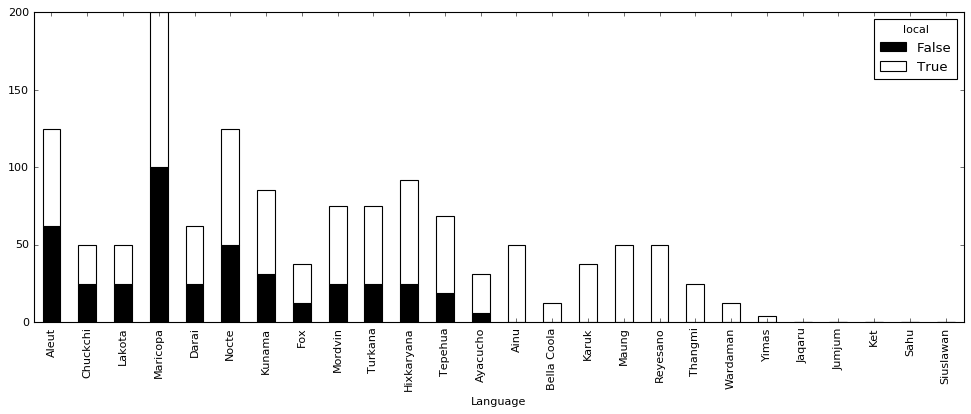

In [13]:
rf.sort_values(by=('ratio (norm)', True), kind='mergesort')['ratio']\
    .plot.bar(stacked=True, figsize=(15, 5), cmap=plt.cm.gray);

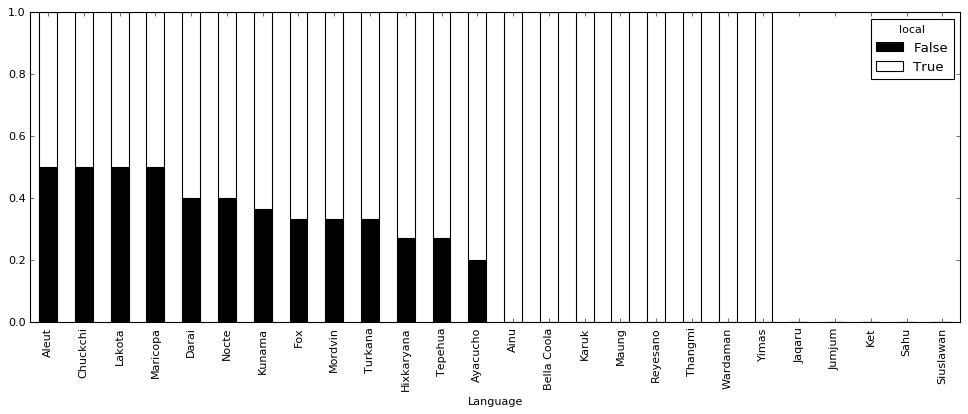

In [14]:
rf['ratio (norm)'].sort_values(by=True, kind='mergesort')\
    .plot.bar(stacked=True, figsize=(15, 5), cmap=plt.cm.gray);

In [15]:
pd.DataFrame([pearsonr(rfp, 'local', c) for c in ['ratio', 'ratio (norm)']])

,r,p
local & ratio,0.417388,5.957358e-03
local & ratio (norm),0.801603,1.788712e-10
